<a href="https://colab.research.google.com/github/bulkpanda/Image-Segmentation/blob/master/UNet_Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# set files path to system  
import sys
sys.path.append('/content/drive/MyDrive/Image segmentation/UNet')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Loading training data

In [ ]:
import numpy as np
#cache = np.load('/content/drive/MyDrive/Image segmentation/UNet/train_data.npy', allow_pickle=True).item()
cache={}
boundary=np.load('/content/drive/MyDrive/Image segmentation/UNet/boundary_places.npy', allow_pickle=True).item()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from UNet import Model
from UNet import UNetWithResnet50Encoder
from dataloader import data_loader
import config as cg
import matplotlib.pyplot as plt
import numpy as np
import datetime
import logging
import json

In [ ]:
torch.set_printoptions(threshold=np.inf)
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

In [ ]:
def get_cuda_mem(x=''):
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)

    print(f'{x}\nTotal:{t//1024**2}\nReserved:{r//1024**2}\nAllocated:{a//1024**2}\n')

In [ ]:
def train(model, use_cuda, train_loader, optimizer, epoch, train_loss_array,
          start_batch_idx, start_epoch, dirname, accuracy):
    
    datalen=len(train_loader.dataset)
    model.train()
    for i, (image, label, name, bound) in enumerate(train_loader):
        
        if epoch<start_epoch or (epoch==start_epoch and i<start_batch_idx):
            print('\n=====================')
            print(f'Epoch:{epoch}, [{(i+1)*len(image)}/{datalen}]')
            continue
        else:
            
            print('\n=====================')
            print(f'Epoch:{epoch}, [{(i+1)*len(image)}/{datalen}]')
            print(f'Image name:{name}')
            print(f'\nImage shape:{image.shape}')
            torch.cuda.empty_cache()
            
            if use_cuda:
                image, label, bound = image.cuda(), label.cuda(), bound.cuda() # Sending the data to GPU

            optimizer.zero_grad()  # Setting the cumulative gradients to 0
            output = model(image)  # Forward pass through the model 4x20x288x512
            
            output = output.transpose(1,2).transpose(2,3) # 4x288x512x20
            size = output.shape[0]*output.shape[1]*output.shape[2]

            output = output.resize(size,20)
            label_re = label.resize(size)
            
            loss = nn.functional.cross_entropy(output, label_re, reduction='none')  
            bound=bound.resize(size)
            loss=torch.dot(loss, bound)
            loss=torch.sum(loss)/torch.sum(bound)
            loss.backward()
            print(f'Loss :{loss}')                
            optimizer.step()
            train_loss_array.append(loss.item())
            label_re = label_re.data.cpu()
  
            if i % 10 == 0:
                pred = output.argmax(dim=1, keepdim=True).data.cpu()
                acc = pred.eq(label_re.view_as(pred)).sum().item()
                accper=100*acc/len(label_re)
                print(f'Accuracy:{acc}/{len(label_re)}')
                print(f'%accuracy:{accper}')
                accuracy.append(accper)

            if ((i+1)*len(image)%7000) == 0:
                plt.plot(train_loss_array[-700:])
                plt.savefig(f'{dirname}/lossplot_{epoch}_short.png')
                plt.close()

            if ((i+1)*len(image)%7000) == 0:
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss':train_loss_array,
                'batch_idx':i,
                'epoch':epoch,
                'accuracy':accuracy
                }, dirname+'/'+cg.savepath+'/'+str(epoch)+'.pth')
                plt.plot(train_loss_array)
                plt.savefig(f'{dirname}/lossplot_{epoch}.png')
                plt.close()
                plt.plot(accuracy)
                plt.savefig(f'{dirname}/accuracy.png')
                plt.close()

In [ ]:
def getdirname():
    pretrained=''
    if cg.pretrained:
        pretrained='Pretrained'
    root='/content/drive/MyDrive/Image segmentation/UNet/Exp'
    initials=f"Train_UnetResnet_{cg.lr}_{cg.batchsize['train']}"
    ctime=str(datetime.datetime.now())
    date=ctime.split(' ')[0]
    date=date.replace('-','_')
    time=ctime.split(' ')[1]
    time=time.split('.')[0]
    time=time.replace(':', '_')
    ctime=date+'_'+time
    dirname=f'{root}/{initials}_{ctime}_{pretrained}'
    os.makedirs(dirname,exist_ok=True)
    return dirname

In [ ]:
def main(dirname):
    # model=Model()
    model=UNetWithResnet50Encoder()
    savepath=cg.savepath
    
    os.makedirs(dirname+'/'+savepath, exist_ok=True)
    
    print(f'Cuda is available:{torch.cuda.is_available()}')
    if torch.cuda.is_available():
        model.cuda()
        use_cuda=True
    else:
        use_cuda=False

    #=============Data loader==================================================
    print('\nStarting Dataloader...')
    train_loader=data_loader.getdataloader('/content/drive/MyDrive/Image segmentation/UNet/images/images/10k/train',
                           '/content/drive/MyDrive/Image segmentation/UNet/trainlabels/trainlabels',
                           'train',
                            False,
                            cache,
                            boundary
                            )
    print('Data loaded!!')
    
    #==========================================================================
    optimizer = optim.Adam(model.parameters(), lr=cg.lr, betas=(0.9, 0.999), 
                            eps=1e-08, weight_decay=0)
    
    #===============================training===================================
    train_loss_array=[]
    accuracy=[]
    itr=cg.iterations['train']+1
    start_batch_idx=0
    start_epoch=0
    
    if cg.pretrained:
        ckpt=torch.load(cg.savedmodel)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        train_loss_array=ckpt['loss']
        start_epoch=ckpt['epoch']
        start_batch_idx=ckpt['batch_idx']
        print(f'\nWill start from epoch:{start_epoch} and batch_idx:{start_batch_idx}\n')
    print('Opti')
    for epoch in range(1, itr):
        
        train(model, use_cuda, train_loader, optimizer, epoch, 
              train_loss_array, start_batch_idx, start_epoch, dirname,accuracy )
  
    plt.plot([i for i in range(len(train_loss_array))],train_loss_array)
    plt.savefig(f'{dirname}/lossplot.png')
    plt.show()

In [ ]:
if __name__ == '__main__':
    
    dirname= getdirname()
    os.makedirs(f'{dirname}/logfiles', exist_ok=True)
    logger.addHandler(logging.FileHandler(f'{dirname}/logfiles/train.log', 'a',encoding = "UTF-8"))
    print = logger.info
    main(dirname)

##For testing the model

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Image segmentation/UNet')

In [ ]:
import numpy as np
cache = np.load('/content/drive/MyDrive/Image segmentation/UNet/train_data.npy', allow_pickle=True).item()
boundary=np.load('/content/drive/MyDrive/Image segmentation/UNet/boundary_places.npy', allow_pickle=True).item()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from UNet import Model
from UNet import UNetWithResnet50Encoder
from dataloader import data_loader
import config as cg
import matplotlib.pyplot as plt
import numpy as np
import datetime
import logging

In [ ]:
torch.set_printoptions(threshold=np.inf)
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

In [ ]:
def test(model, loader, use_cuda, dirname, acc):

    model.eval()
    with torch.no_grad():
        for i,(image, label, name,_) in enumerate(loader):
        #for i in range(7000):
           # image = cache[i]['image']
            #print(f'shape:{image.shape}')
            image=image.transpose(2,0,1).astype(np.float32)/255
            image=torch.from_numpy(image)
            image=torch.unsqueeze(image,0)
            #print(f'shape:{image.shape}')
            label = cache[i]['label']
            label=label.astype(np.int64)
            label=torch.from_numpy(label)
            print(f'[{i}]')
            torch.cuda.empty_cache()
            
            if use_cuda:
                image = image.cuda() # Sending the data to GPU

            output = model(image)  # Forward pass through the model (1,20,288,512)
            output=output.squeeze() 
            output=output.transpose(0,2).transpose(0,1) # (288,512,20)
            #print(f'Output :{output}')
            pred = output.argmax(dim=2, keepdim=True).data.cpu() #(288,512,1)

            pred=pred.squeeze() #(288,512)
            label = label.squeeze()
            pred[pred == 19] = 255
            label[label == 19] = 255
            #print(f'Prediction:{pred}')
            #print(f'Label:{label}')
            total=288*512
            accuracy = pred.eq(label.view_as(pred)).sum().item()
            #print(f'Name:{name}')
            print(f'Accuracy:{accuracy}/{total}')
            print(f'%:{accuracy*100/total}')
            acc.append(accuracy*100/total)
            if accuracy*100/total<90 or accuracy*100/total>98:
              fig=plt.figure(figsize=(100,100))
              fig.add_subplot(1,2,1)
              pred = pred.numpy()
              plt.imshow(pred,cmap='gray')
              fig.add_subplot(1,2,2)
              plt.imshow(label,cmap='gray')
              plt.savefig(dirname+f'/{i}_{accuracy*100/total}.png')
              plt.close(fig)

In [ ]:
def getdirname():
    root='/content/drive/MyDrive/Image segmentation/UNet/Exp'
    initials='Test_ResUnet'
    ctime=str(datetime.datetime.now())
    date=ctime.split(' ')[0]
    date=date.replace('-','_')
    time=ctime.split(' ')[1]
    time=time.split('.')[0]
    time=time.replace(':', '_')
    ctime=date+'_'+time
    dirname=f'{root}/{initials}_{ctime}_2'
    os.makedirs(dirname,exist_ok=True)
    return dirname

In [ ]:
def main(dirname):
    os.makedirs('./Exp',exist_ok=True)
    data=torch.load('/content/drive/MyDrive/Image segmentation/UNet/Exp/Train_UnetResnet_0.002_10_2021_10_10_04_04_37_Pretrained/models/100.pth')
    loss_array=data['loss']
    
    plt.plot([i for i in range(len(loss_array))],loss_array)
    plt.savefig(dirname+'/lossplot.png')
    plt.show()
    model=UNetWithResnet50Encoder()
    model.load_state_dict(data['model_state_dict'])
    if torch.cuda.is_available() == True:
        use_cuda=True
        model.cuda()
        
    else:
        use_cuda=False
        
    print('Starting Dataloader...')
    test_loader=data_loader.getdataloader('/content/drive/MyDrive/Image segmentation/UNet/images/images/10k/train',
                           '/content/drive/MyDrive/Image segmentation/UNet/trainlabels/trainlabels',
                           'test',
                            True,
                            cache,
                            boundary
                            )
    print('Data loaded!!')
    
    acc=[]

    test(model, test_loader, use_cuda, dirname, acc)
    plt.plot(acc)
    plt.show()
    acc=np.array(acc)
    np.save(f'{dirname}/test_accuracy.npy', acc)


In [ ]:
if __name__ == '__main__':
    dirname=getdirname()
    os.makedirs(f'{dirname}/logfiles',exist_ok=True)
    logger.addHandler(logging.FileHandler(f'{dirname}/logfiles/test.log', 'w',encoding = "UTF-8"))
    print = logger.info
    main(dirname)

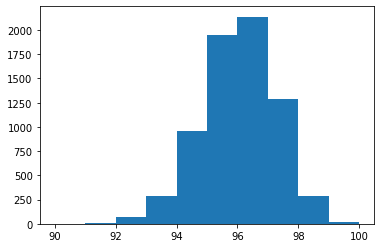

[   0    1    3 ... 6997 6998 6999]
5681
2762
99.86775716145833
Average accuracy:96.05007469540551


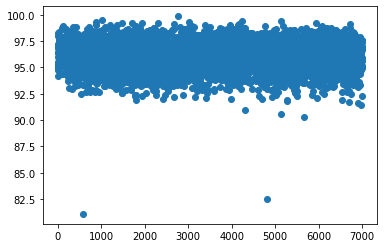

In [ ]:
acc=np.load(f'/content/drive/MyDrive/Image segmentation/UNet/test_accuracy.npy')
plt.hist(acc[acc>=90],bins=[i for i in range(90,101)])
plt.show()
lowacc=np.where(acc>95)[0]
print(lowacc)
print(len(lowacc))
max=np.argmax(acc)
print(max)
print(acc[max])
avg=np.mean(acc)
print(f'Average accuracy:{avg}')
plt.scatter([i for i in range(7000)],acc)
plt.show()

Only images @ 578,4814 have accuracy < 90% <br>
1319 images have accuracy b/w 90-95% <br>
5681 images have accuracy > 95% <br>
1592 images have accuracy > 97% <br>
303 images have accuracy > 98% <br>


##CRF testing

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Image segmentation/UNet')
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-bhludbd1
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-bhludbd1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from UNet import Model
from UNet import UNetWithResnet50Encoder
from dataloader import data_loader
import config as cg
import matplotlib.pyplot as plt
import numpy as np
import datetime
import logging
import pydensecrf.densecrf as dcrf

In [ ]:
cache = np.load('/content/drive/MyDrive/Image segmentation/UNet/train_data.npy', allow_pickle=True).item()
# boundary=np.load('/content/drive/MyDrive/Image segmentation/UNet/boundary_places.npy', allow_pickle=True).item()

In [ ]:
torch.set_printoptions(threshold=np.inf)
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

In [ ]:
model=UNetWithResnet50Encoder()
data=torch.load('/content/drive/MyDrive/Image segmentation/UNet/Exp/Train_UnetResnet_0.002_10_2021_10_10_04_04_37_Pretrained/models/100.pth')
model.load_state_dict(data['model_state_dict'])
if torch.cuda.is_available() == True:
    use_cuda=True
    model.cuda()
model.eval()

UNetWithResnet50Encoder(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (input_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)


Min accuracy for i=578 @ 81%, 
Max accuracy for i=2762 @ 99.86%

Without CRF

[0]
Accuracy:141533/147456
%:95.98320855034723


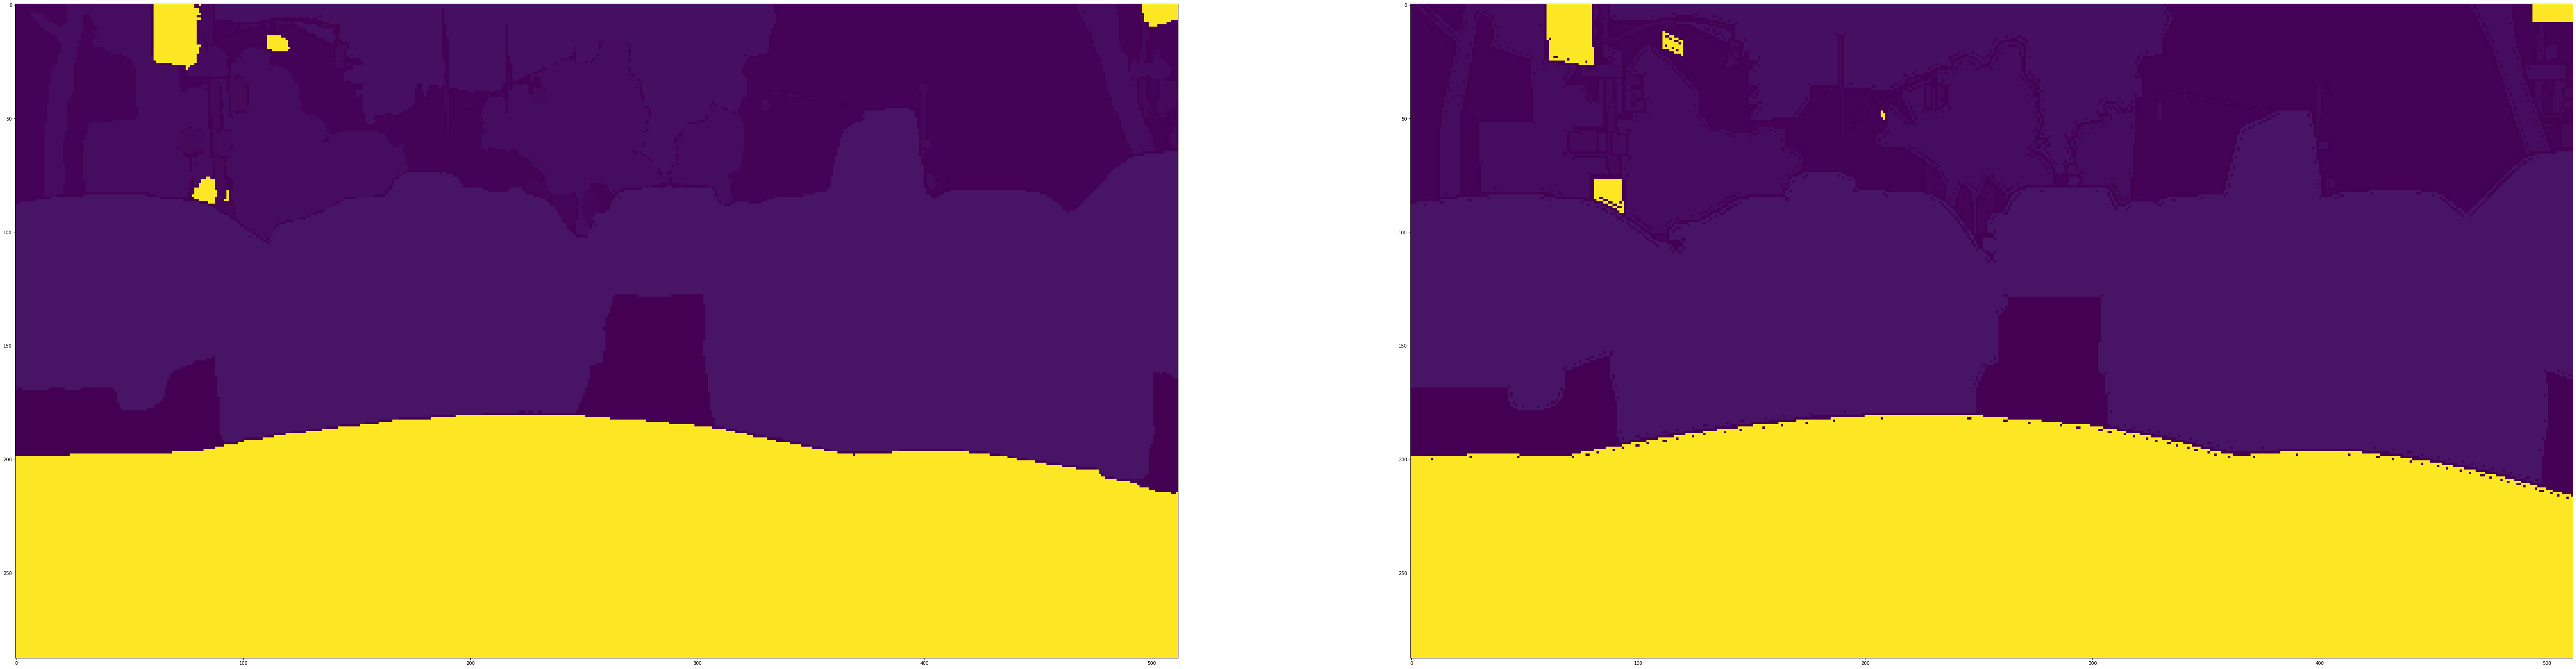

In [ ]:
i=0
image = cache[i]['image']                                 #(288,512,3)
image=image.transpose(2,0,1).astype(np.float32)/255       #(3,288,512)
image=torch.from_numpy(image)                             #(3,288,512)
image=torch.unsqueeze(image,0)                            #(1,3,288,512)

label = cache[i]['label']                                 #(288,512,1)
label=label.astype(np.int64)
label=torch.from_numpy(label)                             #(288,512,1)
print(f'[{i}]')
torch.cuda.empty_cache()

if use_cuda:
    image = image.cuda()                                  # Sending the data to GPU

output = model(image)                                     # Forward pass through the model (1,20,288,512)
output=output.squeeze()                                   #(20,288,512)
output=output.transpose(0,2).transpose(0,1)               # (288,512,20)
pred = output.argmax(dim=2, keepdim=True).data.cpu()      #(288,512,1)

pred=pred.squeeze()                                       #(288,512)
label = label.squeeze()                                   #(288,512)
pred[pred == 19] = 255
label[label == 19] = 255

total=288*512
accuracy = pred.eq(label.view_as(pred)).sum().item()

print(f'Accuracy:{accuracy}/{total}')
print(f'%:{accuracy*100/total}')

fig=plt.figure(figsize=(100,100))
fig.add_subplot(1,2,1)
pred = pred.numpy()
plt.imshow(pred)
fig.add_subplot(1,2,2)
plt.imshow(label)
plt.show()

With CRF

[0]
*********************************************
*********************************************
sxy:0
Compat:[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


Accuracy:141533/147456
%:95.98320855034723


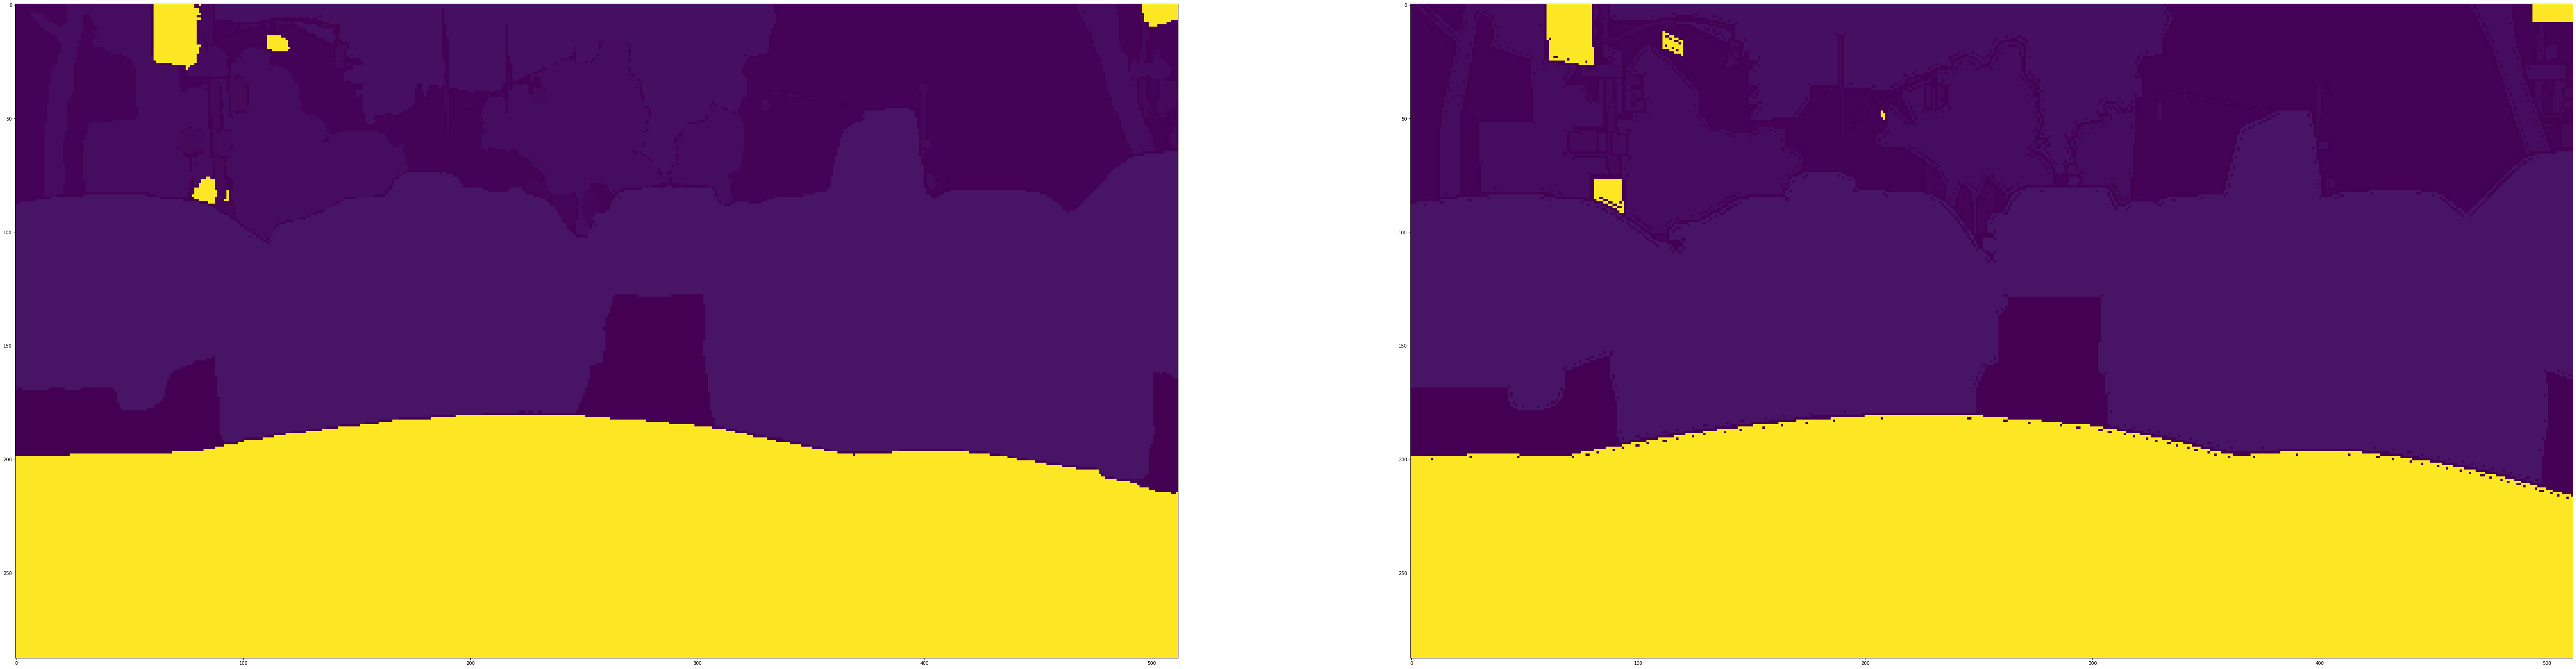

Compat:[1]
Accuracy:141472/147456
%:95.94184027777777


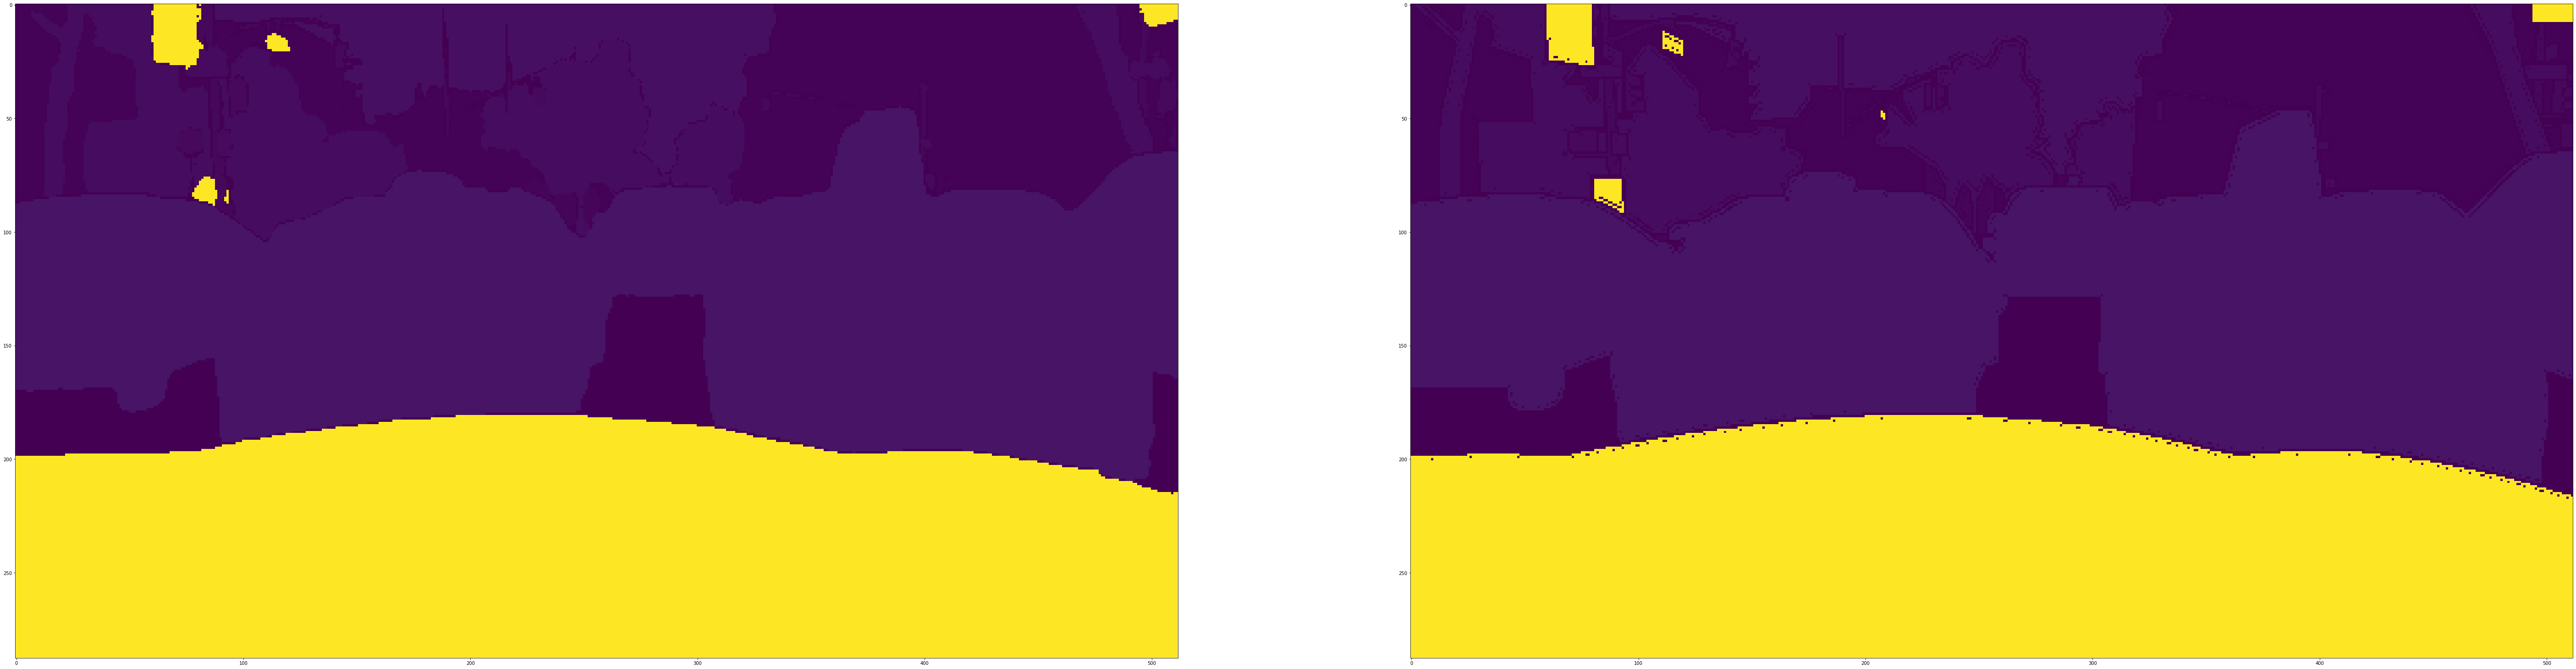

Compat:[2]
Accuracy:141371/147456
%:95.87334526909723


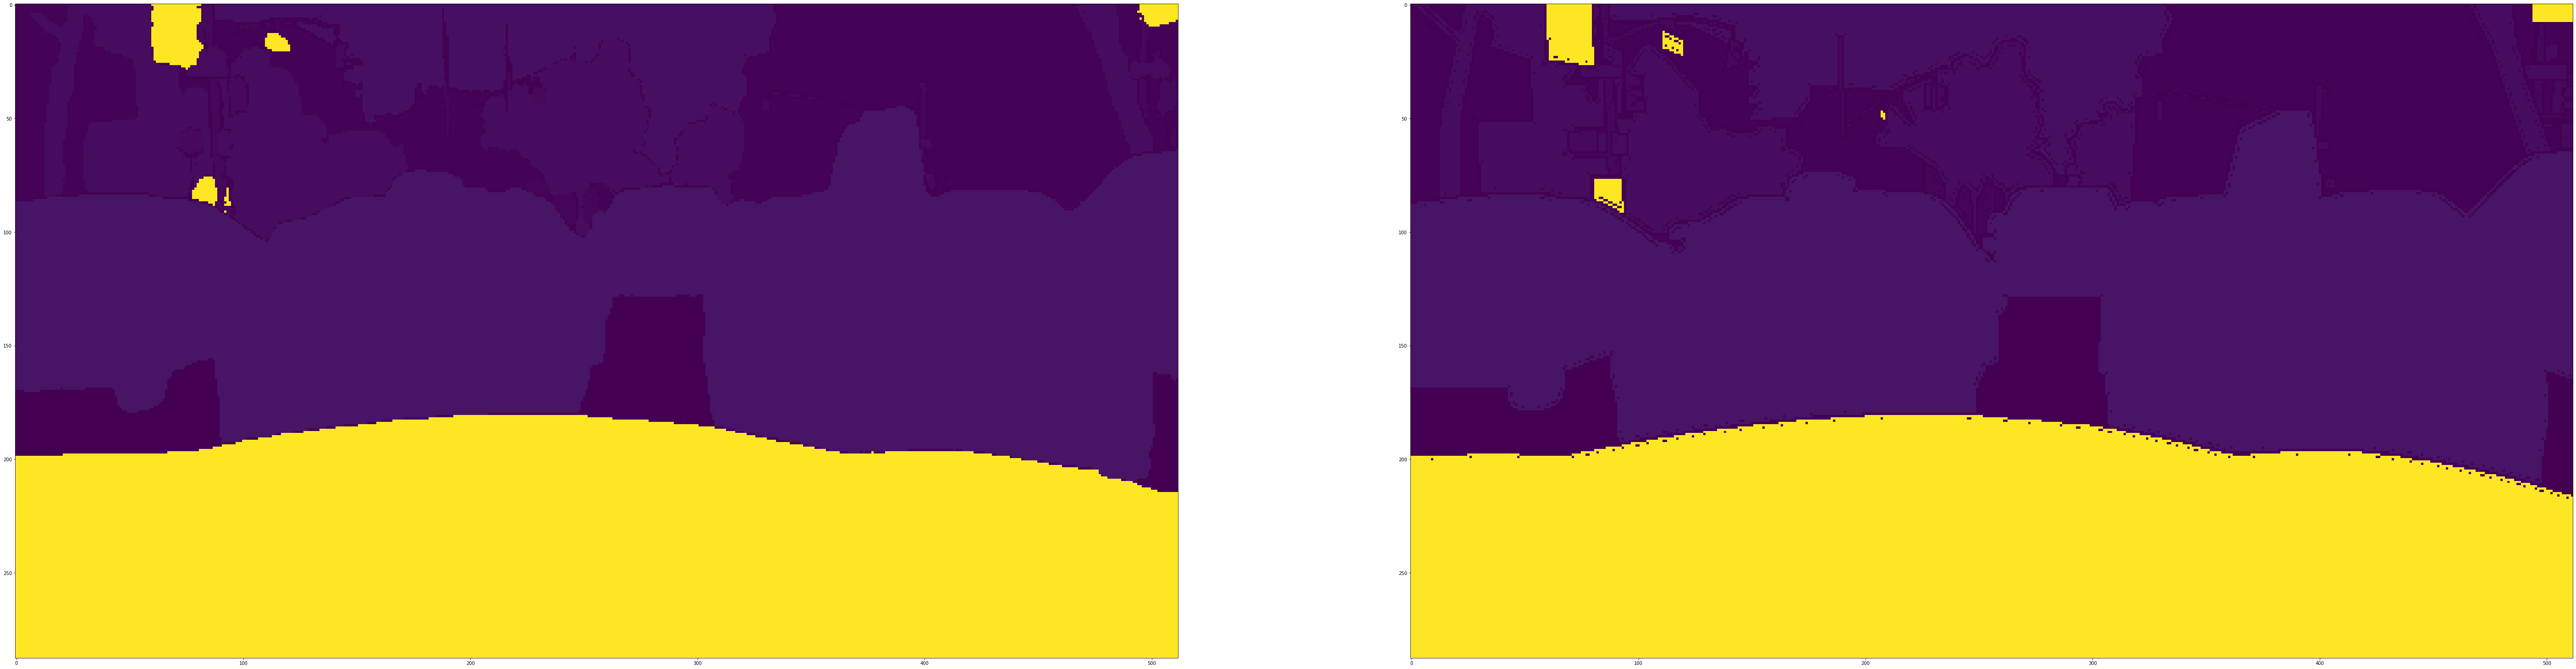

Compat:[3]
Accuracy:141255/147456
%:95.794677734375


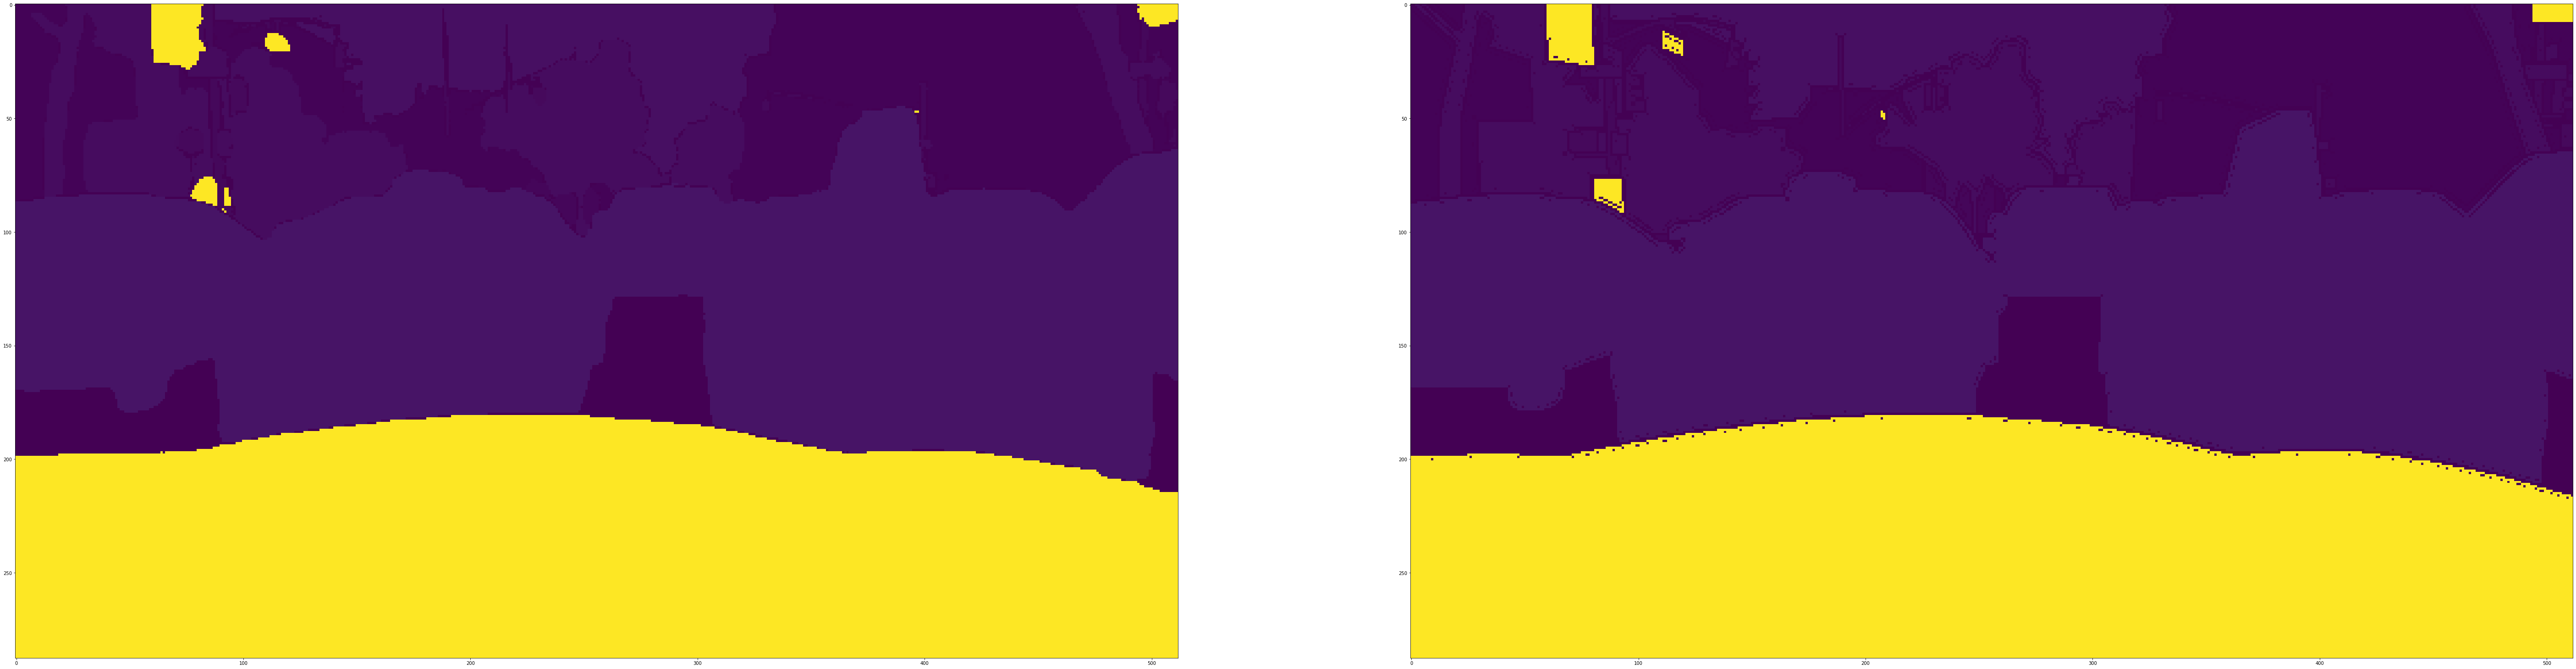

Compat:[4]
Accuracy:141111/147456
%:95.697021484375


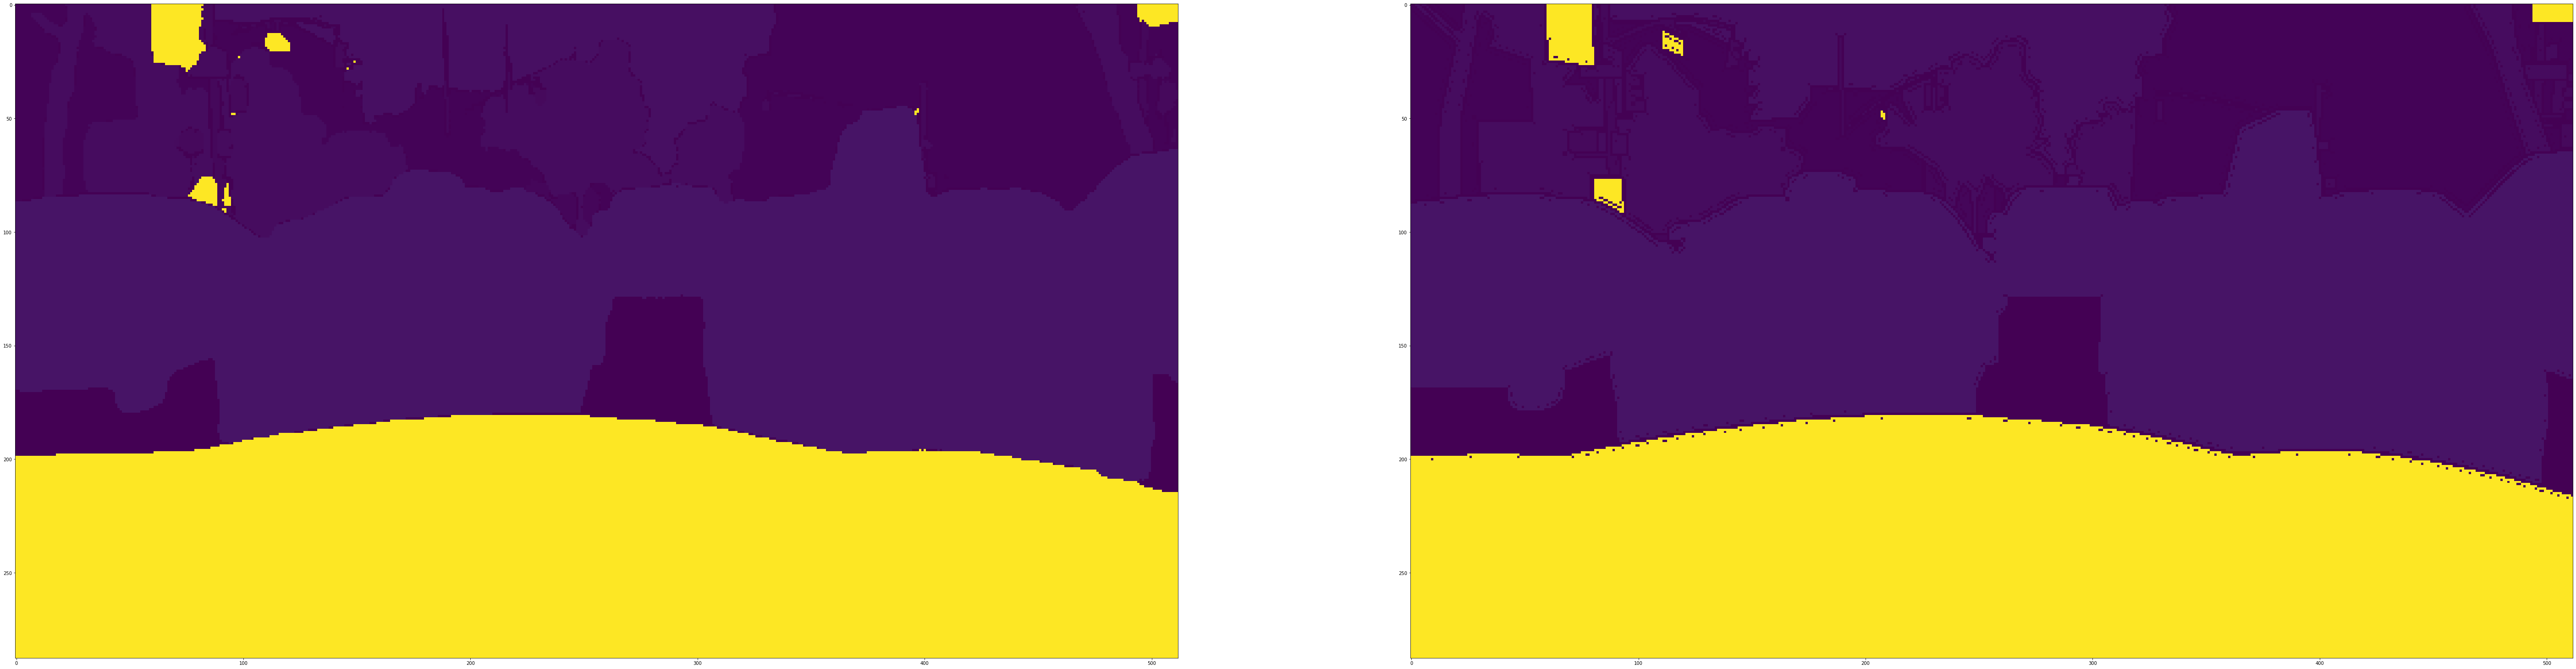

Compat:[5]
Accuracy:140948/147456
%:95.58648003472223


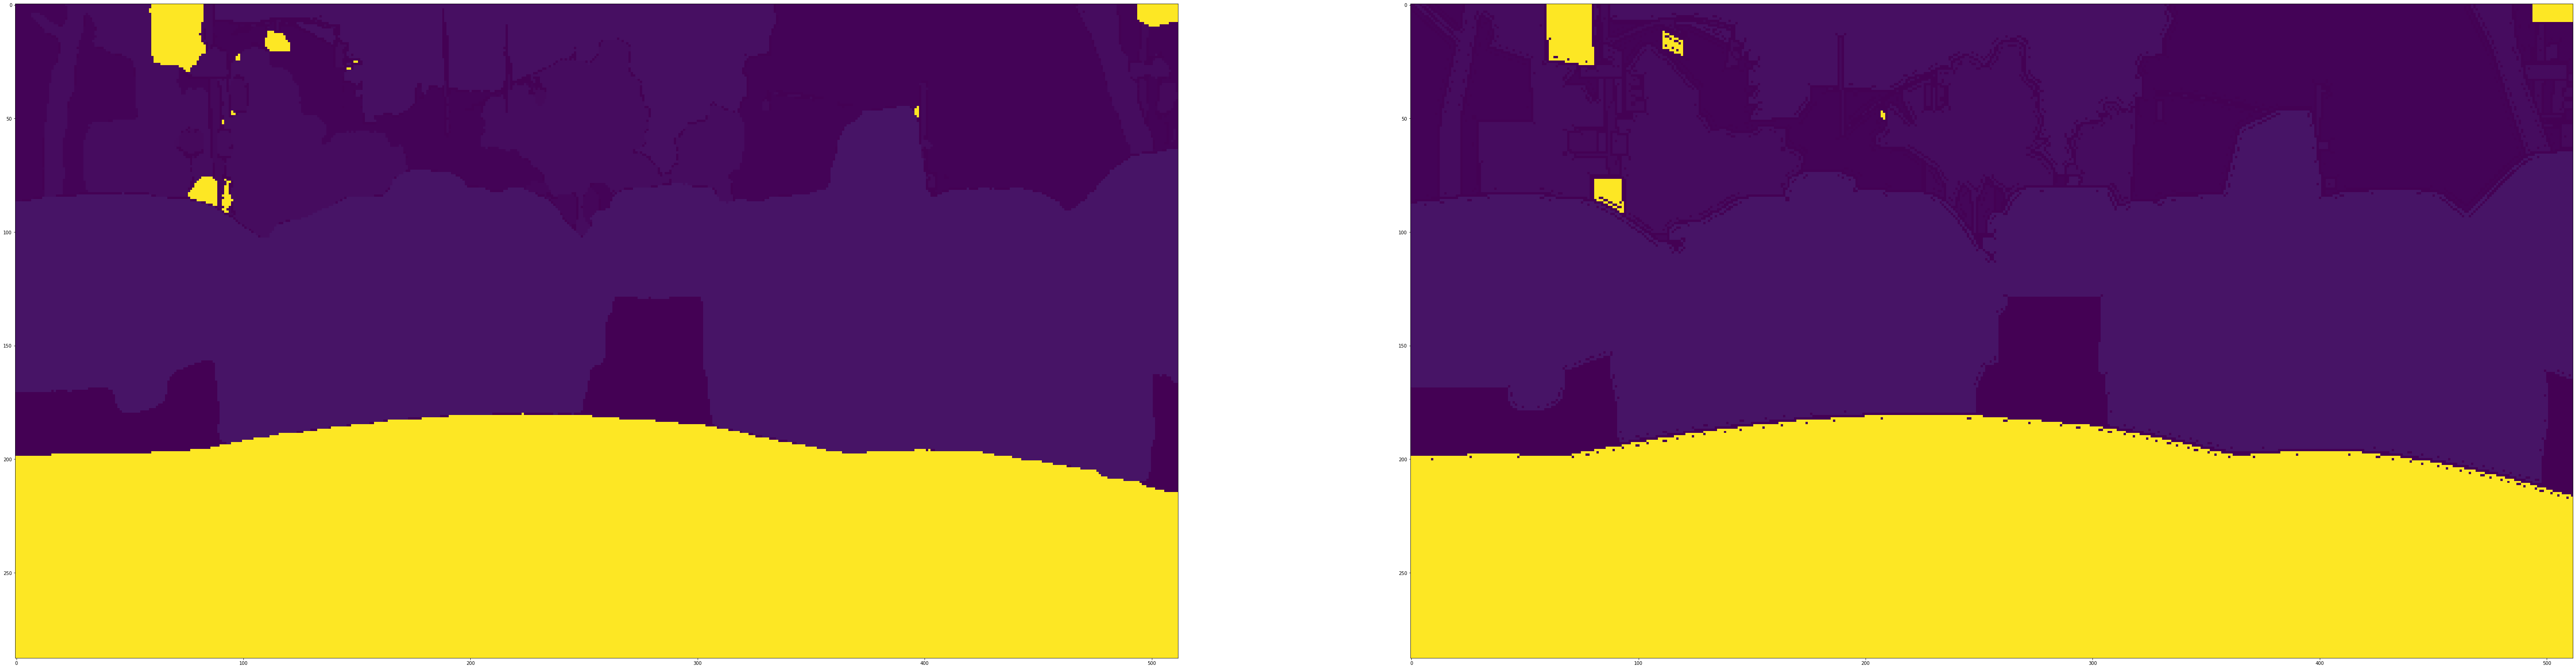

Compat:[6]
Accuracy:140797/147456
%:95.48407660590277


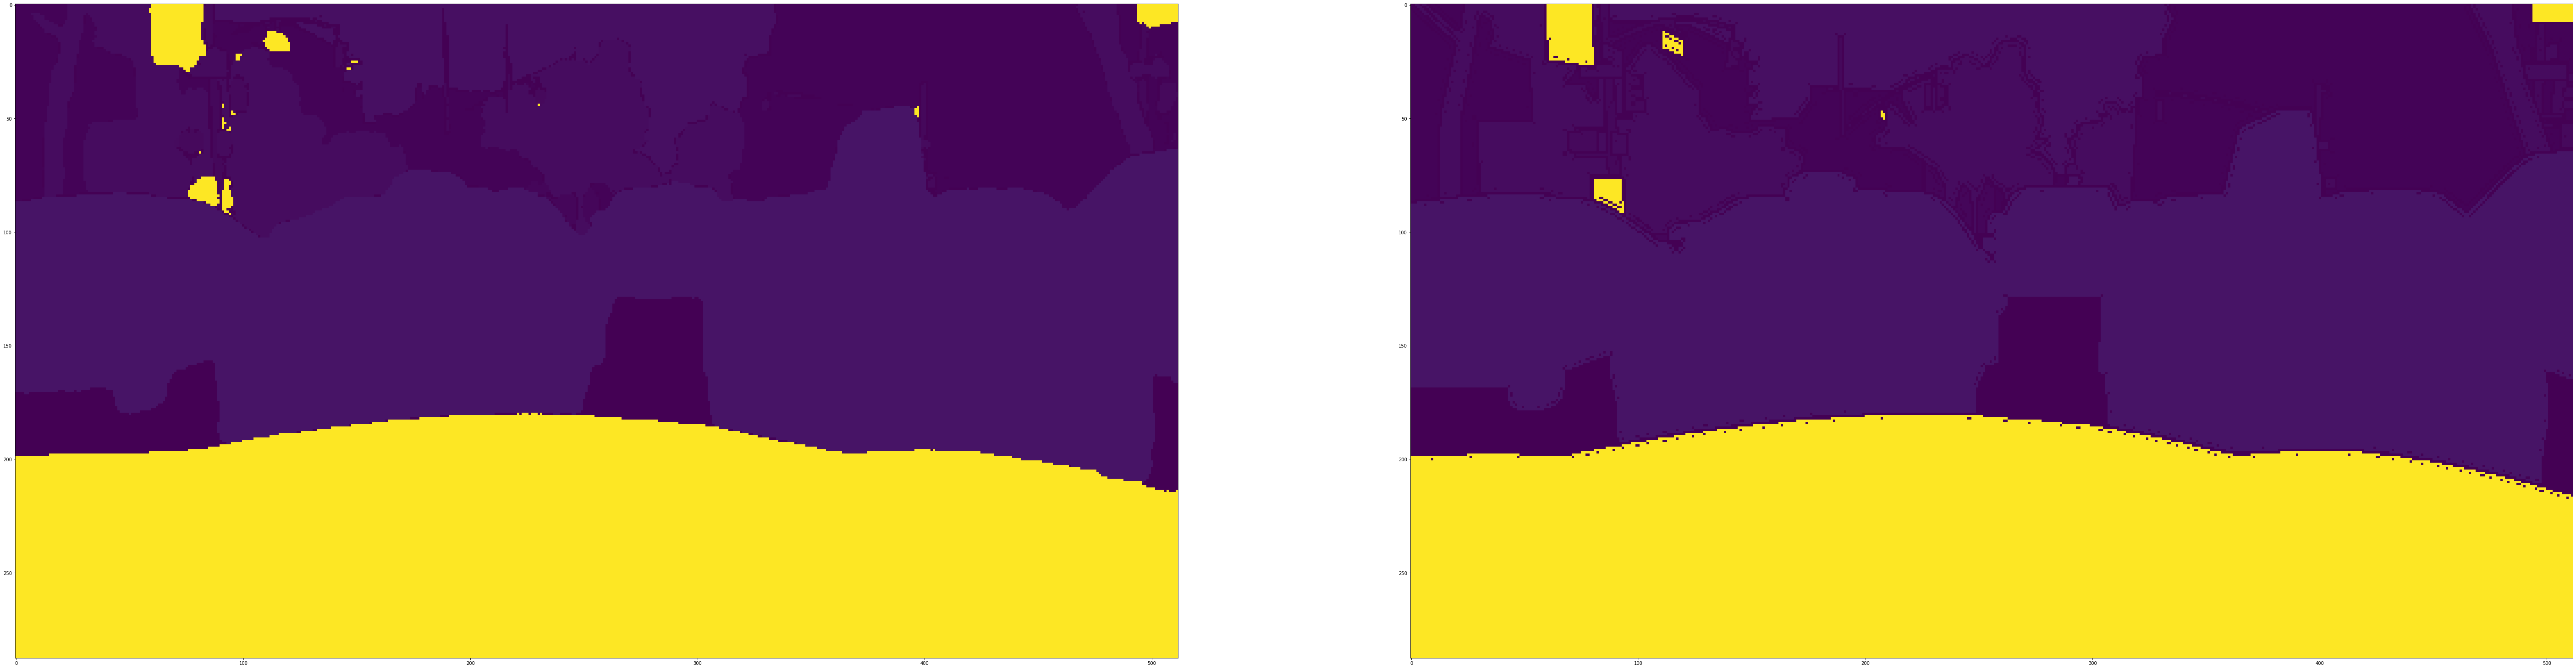

In [ ]:
i=0
print(f'[{i}]')
r1=20
r2=10
matrix=np.zeros((r1,r2))
for k in range(r1):
  print('*********************************************')
  print('*********************************************')
  print(f'sxy:{k}')
  for j in range(r2):
    image = cache[i]['image']                                 #(288,512,3)
    image=image.transpose(2,0,1).astype(np.float32)/255       #(3,288,512)
    image=torch.from_numpy(image)                             #(3,288,512)
    image=torch.unsqueeze(image,0)                            #(1,3,288,512)

    label = cache[i]['label']                                 #(288,512,1)
    label=label.astype(np.int64)
    label=torch.from_numpy(label)                             #(288,512,1)
    print('==========================')
    print(f'Compat:[{j}]')
    torch.cuda.empty_cache()

    if use_cuda:
        image = image.cuda()                                  # Sending the data to GPU

    output = model(image)                                     # Forward pass through the model (1,20,288,512)
    output=output.squeeze()                                   #(20,288,512)

    d = dcrf.DenseCRF2D(288, 512, 20)

    soft = nn.Softmax(dim=0)
    prob = soft(output)
    # sum_ = torch.sum(prob[:,0,0])
    # print(sum_)
    prob=np.array(prob.data.cpu())
    U = -np.log(prob)
    # print(U.shape)                                            # classes,width, height
    # print(U.dtype)                                            # float32
    U = U.reshape((20,-1))                                    # classes,width*height
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=k, compat=j)

    Q = d.inference(10)
    pred = np.argmax(Q, axis=0).reshape((288,512))

    pred=pred.squeeze()                                       #(288,512)
    label = label.squeeze()                                   #(288,512)
    pred[pred == 19] = 255
    label[label == 19] = 255

    total=288*512
    pred=torch.from_numpy(pred)
    accuracy = pred.eq(label.view_as(pred)).sum().item()
    per_acc=accuracy*100/total
    matrix[k,j]=per_acc
    print(f'Accuracy:{accuracy}/{total}')
    print(f'%:{per_acc}')

    # fig=plt.figure(figsize=(100,100))
    # fig.add_subplot(1,2,1)
    # pred = pred.numpy()
    # plt.imshow(pred)
    # fig.add_subplot(1,2,2)
    # plt.imshow(label)
    # plt.show()
max=np.argmax(matrix)
print(matrix)
print(max)